# Model the Total Cost of Ownership for electric transport vehicles

Jakolien van der Meer

HZ University of Applied Sciences

### Import libraries

Import libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import xlwings as xw
import matplotlib.pyplot as plt
import random
import decimal
import math
#import binascii
import xarray as xr
from datetime import date
from IPython.display import display, HTML
%matplotlib inline

### Run Excell spreadsheet Topsector Logistiek

To be able to calculate the TCO value for several input values, we rewrite values in the excel sheet and then import the results in this notebook.

In [2]:
# set path to xslm file
path = r'C:\Users\meer0084\Documents\test.xlsm'

# Connect to existing workbook containing VBA macro
wb = xw.Book(path)

# open sheet
ws = wb.sheets['TCO module ondernemers']

# Reset the values to default values
wb.macro('reset_values_ondernemers')()
wb.macro('reset_values_beleidsmakers')()
wb.macro('reset_values_model_parameters')() # added to sheet

# xw.apps.keys()
# wb = xw.apps[10300].books[path]

Ask the user for input values and insert in excel sheet.

In [3]:
# ask for input values
vtype = str(input('Voertuigtype: ')) # {Kleine bakwagen (12t), Grote bakwagen (18t), Trekker-oplegger}
koeling = str(input('Koelmachine (J/N): ')) # {gekoeld, niet gekoeld}
km_per_year = int(input('Verwacht jaarkilometrage: ')) # > 0
el = str(input('Grijze/groene elektriciteit: ')) # {grijs, groen}
cap = input('Capaciteit vrachtwagenbatterij: ') # {160,200,240}, default value = 160
kwh = input('Vermogen eigen oplaadsysteem: ') # {3,7 , 20, 50, 150, 350} kWh, default value = 20

# check values
if vtype not in {Kleine bakwagen (12t), Grote bakwagen (18t), Trekker-oplegger}

# insert input values in sheet, if empty insert default values
ws.range('B12').value = vtype  
ws.range('B13').value = 'gekoeld' if koeling in {'J', 'j', 'ja', 'Ja'} else 'niet gekoeld' 
ws.range('B14').value = km_per_year 
ws.range('B15').value = el 
ws.range('E13').value = cap
ws.range('E15').value = kwh

# save file
wb.save(path)

Voertuigtype: Kleine bakwagen (12t)
Koelmachine (J/N): j
Verwacht jaarkilometrage: 30000
Grijze/groene elektriciteit: grijs
Capaciteit vrachtwagenbatterij: 
Vermogen eigen oplaadsysteem: 


Read results from workbook and put in a list, then show in a table.

In [4]:
kosten_post = []
thuis_opladen = []
optimale_mix = []
diesel = []

for i in [62,76,81,91,101,104,105]:
    x = 'A' + str(i)
    kosten_post.append(ws.range('A' + str(i)).value)
    thuis_opladen.append(ws.range('C'+ str(i)).value)
    optimale_mix.append(ws.range('D'+ str(i)).value)
    diesel.append(ws.range('E' + str(i)).value)
    
# show table with results
data = np.transpose(np.vstack((np.asarray(thuis_opladen, dtype='float'), np.asarray(diesel, dtype='float')))) 
columns = ['EV', 'Diesel']
index = np.asarray(kosten_post)
frame = pd.DataFrame(data, index=index, columns=columns)
frame

,EV,Diesel
a: Totale vaste voertuigkosten per jaar,9708.6589,4669.8770
b: Totale variabele voertuigkosten per jaar,26209.1183,16486.4099
c: Totale kosten oplaadsysteem per jaar,447.0000,0.0000
d: Totale chauffeurskosten per jaar,73944.0000,73944.0000
e: Totale overhead per jaar,17649.4044,15216.0459
Totale kosten per km: (a+b+c+d+e)/ kms per jaar,4.2653,3.6772
Totale kosten per uur: (a+b+c+d+e)/ uren per jaar,49.2147,42.4294


Plot the tco components for EV and diesel.

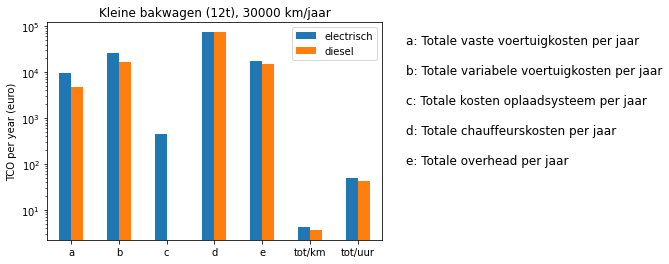

In [5]:
# convert list to float type for plotting
data1 = np.asarray(thuis_opladen, dtype='float');
data2 = np.asarray(diesel, dtype='float');

# Make bar plot
index = ['a', 'b', 'c', 'd', 'e', 'tot/km','tot/uur']
df = pd.DataFrame({'electrisch': data1,
                   'diesel': data2}, index=index)

ax = df.plot.bar(rot=0)
ax.set_yscale('log')
title = vtype + ', ' + str(km_per_year) + ' km/jaar'
ax.set_title(title);
ax.set_ylabel('TCO per year (euro)')
textstr = '''a: Totale vaste voertuigkosten per jaar\n 
b: Totale variabele voertuigkosten per jaar\n 
c: Totale kosten oplaadsysteem per jaar\n
d: Totale chauffeurskosten per jaar\n
e: Totale overhead per jaar'''      
# print textstr
plt.text(7, 100, textstr, fontsize=12)
plt.show()

Plot as a stacked diagram.

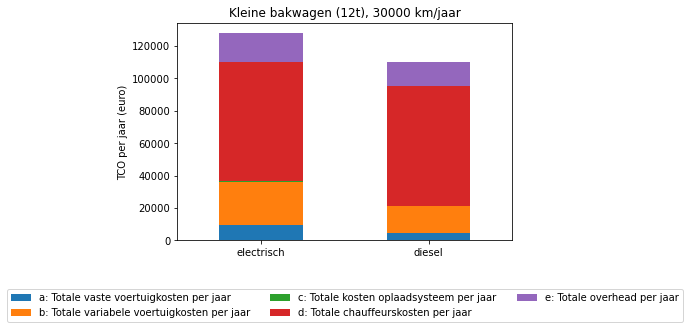

In [6]:
df = pd.DataFrame({'a: Totale vaste voertuigkosten per jaar': [data1[0],data2[0]],
                   'b: Totale variabele voertuigkosten per jaar': [data1[1],data2[1]],
                   'c: Totale kosten oplaadsysteem per jaar': [data1[2],data2[2]],
                   'd: Totale chauffeurskosten per jaar': [data1[3],data2[3]],
                   'e: Totale overhead per jaar': [data1[4],data2[4]]
                  }, index=['electrisch','diesel'])

ax = df.plot(kind='bar', stacked=True, rot=0)
ax.set_title(title);
ax.set_ylabel('TCO per jaar (euro)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3);

make a pie plot.

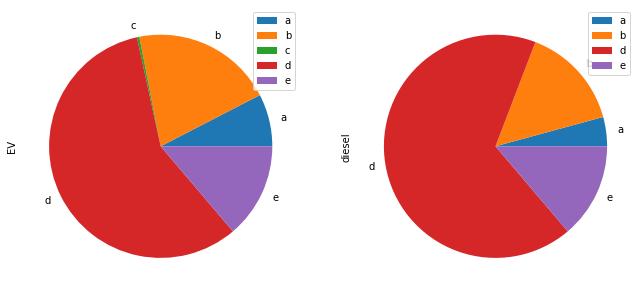

In [7]:
df = pd.DataFrame({'EV': [data1[0], data1[1] , data1[2], data1[3],data1[4]],
                   'diesel': [data2[0], data2[1] , data2[2], data2[3],data2[4]]},
                  index=['a', 'b', 'c', 'd', 'e'])
plot = df.plot.pie(subplots=True, figsize=(11, 6))

Calculate and plot the total costs per year vs the number of km/year.

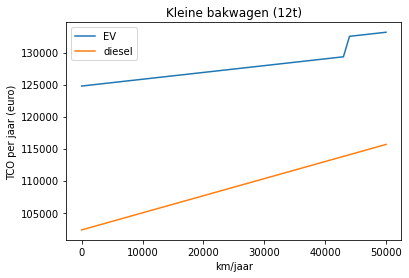

In [8]:
km_per_year = []
tco_per_year = []
tco_per_year_diesel = []

# define km/year range
def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

# fetch tco for certain amount of kms and append to list
for km in my_range(0,50000,1000):
    km_per_year.append(km)
    
    # write kms to sheet
    ws.range('B14').value = km
    
    # read costs from sheet
    tco_per_year.append(ws.range('C44').value)
    tco_per_year_diesel.append(ws.range('E44').value)
    
# calculate variance
#min_std = [[y - x * decimal.Decimal(0.002) for y in tco_per_year] for x in km_per_year]
#plus_std = [[y + x * decimal.Decimal(0.002) for y in tco_per_year] for x in km_per_year]

# plot costs vs km 
plt.plot(km_per_year,tco_per_year, label = 'EV')
#plt.fill_between(km_per_year,min_std, plus_std, alpha = 0.5)
plt.plot(km_per_year,tco_per_year_diesel, label = 'diesel')
plt.xlabel('km/jaar')
plt.ylabel('TCO per jaar (euro)')
plt.title(vtype)
plt.legend(loc='best')
plt.show()

Do the same for co2.

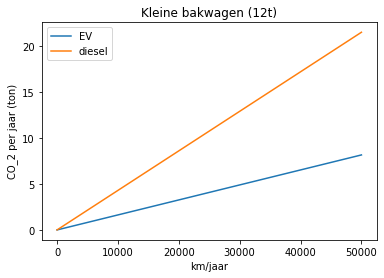

In [9]:
co2_per_year = []
co2_per_year_diesel = []

# fetch tco for certain amount of kms and append to list
for km in km_per_year:
    
    # write kms to sheet
    ws.range('B14').value = km
    
    # read costs from sheet
    co2_per_year.append(ws.range('C49').value)
    co2_per_year_diesel.append(ws.range('E49').value)
    
# plot co2 vs km 
plt.plot(km_per_year,co2_per_year, label = 'EV')
plt.plot(km_per_year,co2_per_year_diesel, label = 'diesel')
plt.xlabel('km/jaar')
plt.ylabel('CO_2 per jaar (ton)')
plt.title(vtype)
plt.legend(loc='best')
plt.show()

Show all the results in a table.

In [10]:
kosten_post = []
thuis_opladen = []
optimale_mix = []
diesel = []

for i in range(33,105):
    x = 'A' + str(i)
    kosten_post.append(ws.range('A' + str(i)).value)
    thuis_opladen.append(ws.range('C'+ str(i)).value)
    optimale_mix.append(ws.range('D'+ str(i)).value)
    diesel.append(ws.range('E' + str(i)).value)
    
# show table with results
data = np.transpose(np.vstack((np.asarray(thuis_opladen), np.asarray(optimale_mix), np.asarray(diesel)))) 
columns = ['EV thuis opladen', 'EV optimale mix', 'Diesel']
kosten_post = ['' if v is None else v for v in kosten_post] # replace None by empty string
index = np.asarray(kosten_post)
df = pd.DataFrame(data, index=index, columns=columns)
df = df.replace(np.nan, '', regex=True) # replace nan by empty string

display(HTML(df.to_html()))

,EV thuis opladen,EV optimale mix,Diesel
RESULTATEN,,,
Scenario,Uitsluitend thuis opladen,Optimale mix,Diesel
Scenario technisch mogelijk/niet mogelijk,Scenario valid,Scenario valid,Scenario valid
,,,
Voertuigtype,Kleine bakwagen (12t) 120 kWh,Kleine bakwagen (12t) 120 kWh,Kleine bakwagen (12t)
Eigen oplaadsysteem,AC20,AC20,nvt
Openbaar oplaadsysteem,AC20,AC10,nvt
,,,
Percentage eigen oplaadsysteem,1,1,nvt
Percentage extern (openbaar) oplaadsysteem,0,0,nvt


### Include a time axis to the model

To come up with a smart TCO model that includes the evaluation of the cost components in time, we need to define a time scale first.

In [11]:
year = []
year.append(date.today().year)
nr_of_years = 15
for i in range(1,nr_of_years): 
    year.append(year[-1]+1) 

print(year)

[2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035]


We predict a certain change in vehicle prices for both diesel and electric vehicles.

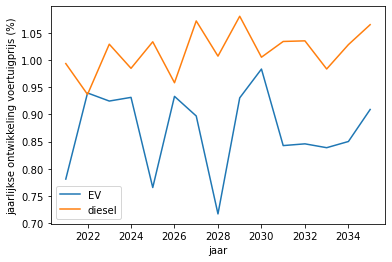

In [12]:
mean = 0.9 # average yearly decrease
std = 0.07
mean_diesel = 1.02
std_diesel = 0.03
decrease_in_price = np.random.normal(mean,std,nr_of_years)
increase_diesel_price =  np.random.normal(mean_diesel,std_diesel,nr_of_years)
plt.plot(year,decrease_in_price, label = 'EV')
plt.plot(year,increase_diesel_price, label = 'diesel')
plt.xlabel('jaar')
plt.ylabel('jaarlijkse ontwikkeling voertuigprijs (%)')
plt.legend(loc='best')
plt.show()

This is multiplied by the current vehicle prices that can be read from the excel sheet 'Model parameters'.

In [13]:
# open model parameters
mp = wb.sheets['Model parameters']

vehicle_price = []
vehicle_price_diesel = []

# get current vehicle price
vehicle_price = [np.asarray(mp.range('E3:E11').value, dtype='int')] # EV
vehicle_price_diesel = [np.asarray(mp.range('E18:E20').value, dtype='int')] # Diesel

# multiply with predicted factor to get purchase price 2021-2030
for i in range(1,nr_of_years): 
    new_price = decrease_in_price[i] * vehicle_price[-1]
    vehicle_price = np.append(vehicle_price, [new_price], axis=0)
    new_diesel_price = increase_diesel_price[i] * vehicle_price_diesel[-1]
    vehicle_price_diesel = np.append(vehicle_price_diesel, [new_diesel_price], axis=0)

# convert to integer
vehicle_price=vehicle_price.astype(int)
vehicle_price_diesel=vehicle_price_diesel.astype(int)

The mean and standard deviation can be drawn from the data.

In [14]:
# calculate mean
mean =  vehicle_price[:,5]
mean_diesel = vehicle_price_diesel[:,1]

# set standard deviation
standard_dev = std * np.mean(vehicle_price[:,5], axis=0) 
standard_dev_diesel = std_diesel * np.mean(vehicle_price_diesel[:,2])

We can plot the price evolution for a certain type of vehicle, with a band denoting the standard deviation.

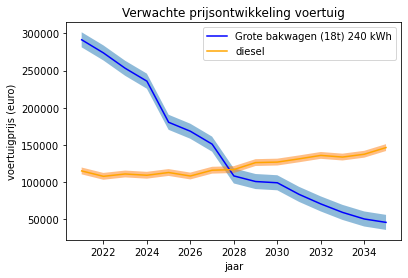

In [15]:
# plot price evolution in time
plt.plot(year,mean, c='blue', label = 'Grote bakwagen (18t) 240 kWh');
plt.fill_between(year, mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.plot(year,mean_diesel, c='orange', label ='diesel');
plt.fill_between(year, mean_diesel-standard_dev_diesel, mean_diesel+standard_dev_diesel, alpha = 0.5)
plt.xlabel('jaar')
plt.ylabel('voertuigprijs (euro)')
plt.title('Verwachte prijsontwikkeling voertuig');
plt.legend(loc='best')
plt.show()

Predict the evolution of the action radius in time, which we assume is growing logarithmicly:

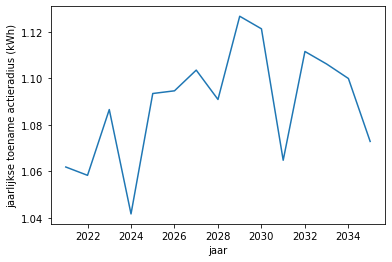

In [16]:
# N.B. Actie radius is alleen van belang voor eerste 5 jaar vanaf nu, dan zal er waarschijnlijk voldoende zijn
# Laadcapaciteit kan hier nog wel een issue vormen
f = lambda x,a : a * x **0.02 
a = math.exp(1)
x = np.linspace(20,1,nr_of_years) # array between 1 and 20, of length nr_of_years
y = f(x,a)
mean = 0.05
std = 0.03
increase_kWh = np.log(y) + np.random.normal(mean,std,nr_of_years)
plt.plot(year,increase_kWh)
plt.xlabel('jaar')
plt.ylabel('jaarlijkse toename actieradius (kWh)')
plt.show()

In [17]:
# get current action radius and vehicle models
action_radius = [np.asarray(mp.range('D3:D11').value, dtype='int')] 
vehicle_model = [mp.range('A3:A11').value]

column_length = len(vehicle_model[-1])

for i in range(1,nr_of_years):  
    new = action_radius[-1]*increase_kWh[i]
    action_radius = np.append(action_radius, [new], axis=0)
    
    # overwrite last part of each string describing action-radius vehicle model
    new_str = []
    for j in range(0,column_length):
        kWh = str(int(new[j]))
        old_kWh = str(int(action_radius[-2][j]))
        if len(old_kWh) < 3: 
            new_str.append(vehicle_model[-1][j][0:-6] + kWh + ' kWh')
        elif len(old_kWh) > 3:
            new_str.append(vehicle_model[-1][j][0:-8] + kWh + ' kWh')
        else:
            new_str.append(vehicle_model[-1][j][0:-7] + kWh + ' kWh')
        
    vehicle_model.append(new_str)

# convert to int
action_radius = action_radius.astype(int)

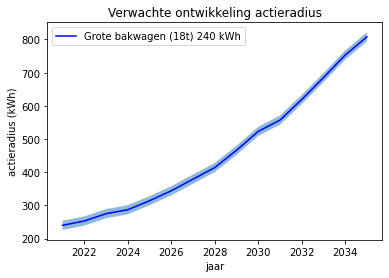

In [18]:
# plot action radius in time
mean = action_radius[:,5]
standard_dev = std * np.mean(action_radius[:,5])
plt.plot(year,mean, c='blue', label = 'Grote bakwagen (18t) 240 kWh');
plt.fill_between(year, mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.xlabel('jaar')
plt.ylabel('actieradius (kWh)')
plt.title('Verwachte ontwikkeling actieradius');
plt.legend(loc='best')
plt.show()

Now we are able to change the input parameters in the excel sheet over the years, and read how the tco values for a certain type of vehicle will evolve accordingly.

In [19]:
# change parameters in Model parameters sheet and read result 
tco_per_year = []
tco_per_year_diesel = []
a = []
b = []
c = []
d = []
e = []
vtype = str(ws.range('B12').value)
km_per_year = int(ws.range('B14').value)
for i in range(0,nr_of_years):
      
    mp.range('A3:A11').value = np.vstack(vehicle_model[i])    
    mp.range('E3:E11').value = np.vstack(vehicle_price[i])
    mp.range('E18:E20').value = np.vstack(vehicle_price_diesel[i]) # N.B. diesel price cannot be changed in first sheet, make this possible.
    mp.range('D3:D11').value = np.vstack(action_radius[i]) 
    
    # read total costs of ownership plus cost components
    tco_per_year.append(ws.range('C44').value)
    tco_per_year_diesel.append(ws.range('E44').value)
    a.append(ws.range('C62').value)
    b.append(ws.range('C76').value)
    c.append(ws.range('C81').value)
    d.append(ws.range('C91').value)
    e.append(ws.range('C101').value)

# save and close workbook

Again, we can plot the curves for this type of electric and diesel truck.

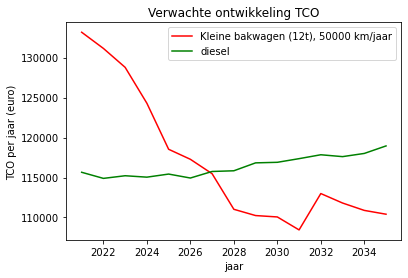

In [20]:
# plot tco evolution in time
mean = tco_per_year
#standard_dev = np.std(tco_per_year) * np.ones(9)
#print(standard_dev)
label = vtype + ', ' + str(km_per_year) + ' km/jaar'
plt.plot(year,tco_per_year, c='red', label = label);
#plt.fill_between(year, mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.plot(year,tco_per_year_diesel, c='green', label ='diesel');
plt.xlabel('jaar')
plt.ylabel('TCO per jaar (euro)')
plt.title('Verwachte ontwikkeling TCO');
plt.legend(loc='best')
plt.show()

Obtain the year of intersection, where 'tco diesel' = 'tco electric'

In [21]:
# find intersection tco/km
i = 0
while i < nr_of_years and tco_per_year[i] > tco_per_year_diesel[i]:
    i+=1

if i < nr_of_years:
    intersect = i
else:
    intersect = len(year) + 1
    
print('year that "TCO EV" = "TCO diesel" = ', intersect)

year that "TCO EV" = "TCO diesel" =  6


Put the results in a histogram.

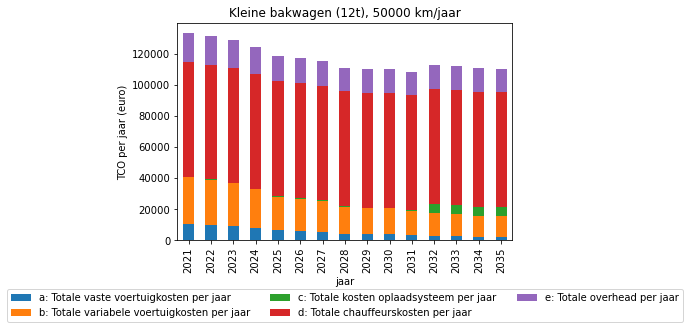

In [22]:
# show costs components in histogram

bins = nr_of_years
data = np.asarray(a, dtype='float')
for x in [b,c,d,e]:
    data = np.vstack((data, np.asarray(x, dtype='float')))

df = pd.DataFrame({'a: Totale vaste voertuigkosten per jaar': data[0],
                   'b: Totale variabele voertuigkosten per jaar': data[1],
                   'c: Totale kosten oplaadsysteem per jaar': data[2],
                   'd: Totale chauffeurskosten per jaar': data[3],
                   'e: Totale overhead per jaar': data[4]
                  }, index=year)

ax = df.plot(kind='bar', stacked=True)
plt.xlabel('jaar')
plt.ylabel('TCO per jaar (euro)')
ax.set_title(label);
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3);

Predict the evolution of the residual value in time

In [23]:
# read from table
residual_value = []
residual_value_diesel = []
decrease_factor = mp.range('B58:B68').value
for i in range(0,10):
    residual_value.append(vehicle_price[0,5] * decrease_factor[i])
    residual_value_diesel.append(vehicle_price_diesel[0,1] * decrease_factor[i])

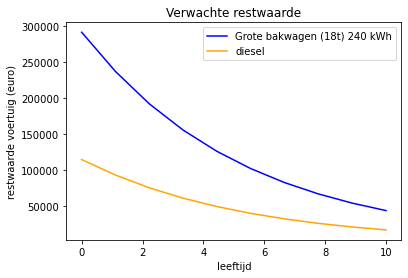

In [24]:
# plot residual value in time
#mean = residual_value
#standard_dev = np.std(residual_value)
age = np.linspace(0,10,10)
plt.plot(age,residual_value, c='blue', label = 'Grote bakwagen (18t) 240 kWh');
plt.plot(age,residual_value_diesel, c='orange', label = 'diesel');
#plt.fill_between(year, mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.xlabel('leeftijd')
plt.ylabel('restwaarde voertuig (euro)')
plt.title('Verwachte restwaarde');
plt.legend(loc='best')
plt.show()

### Find best time to replace diesel vehicle by BEV

There are several strategies that can be followed by a company. We defined three strategies, but the user can also come up with their own stategy.
- strategy 1: replace diesel vehicle with similar electric vehicle if old vehicle is written off
- strategy 2: keep diesel vehicle x years longer, or until tco diesel = tco electric (with max(x) = 5)
- strategy 3: replace old diesel truck with new diesel/hybrid truck truck until year y, where y is the year that tco diesel = tco electric
- strategy 4: replace diesel vehicle as soon as tco_diesel = tco electric

For each strategy we calculate the year of transition to EV's for a certain strategy and economic scenario.

As opposed to the technical life span of a vehicle, the economic life span also takes into account the operational costs compared with alternative vehicles. For example, once electrical vehicles become much cheaper than diesel in operational costs, your diesel truck might be written off after 5 instead of 7 years to avoid having higher costs than your competitors.

Here we read the life span of diesel and electric vehicles and the years one would normally replace the diesel vehicle.

In [25]:
nr_of_strategies = 4

def set_pars(age):
    # set fixed parameters

    # get lifespan diesel truck 
    Ld = int(ws.range('C26').value)
    Le = int(ws.range('B26').value)
    
    # calculate index of the years where you need normally would replace vehicle 
    replace = []
    replace.append(year.index(year[0] + Ld - age))
    for i in range(2):
        replace.append(replace[-1] + Ld)
        
    return Ld, Le, replace

# example
p = set_pars(4)
print('''Life span diesel: {}\n
Life span electric: {}\n
Replace vehicle in: {} and {}'''.format(p[0],p[1],year[p[2][0]],year[p[2][1]]))

Life span diesel: 7

Life span electric: 7

Replace vehicle in: 2024 and 2031


For strategy 2 we can calculate the extra years that an old vehicle is kept onto, with a maximum of x years.

In [26]:
def calculate_extra_years(replace,x,i):
# check how much longer you can keep vehicle
# in case of second strategy
# with a maximum of x years
# in case intersect lies within lifespan of ith vehicle bought after 2021
    if replace[i] + x < intersect:
        return x
    else:
        return intersect - replace[i]
    
# example
x = 3
print('extra years: ', calculate_extra_years(p[2],x,0))

extra years:  3


N.B. Ik gebruik waarden in het jaar dat wordt aangekocht voor de eerste 7 jaar. Dus de vaste kosten (=voertuigprijs) gaan niet omlaag, maar de waarde van electriciteit en diesel doen dat wel en de restwaarde veranderd ook. De kosten van het oplaadsysteem zijn ook afhankelijk van jaar van aankoop. Ik neem ook mee dat de restwaarde van diesel sterk zal dalen vanaf jaar 'intersect' en dat dit dus de vaste kosten over alle jaren daarvoor zal beinvloeden. De restwaarde van electrisch stijgt juist,
verder zullen subsidies alleen de komende paar jaar worden uitgegeven naar alle waarschijnlijkheid.

Based on the year that the tco value of diesel and EV intersect for a certain type of vehicle, the strategy that is prefered, and the current age of the vehicle we can calculate the year that the vehicle is replaced and when to buy electric instead of diesel.

In [27]:
def calculate_transition_year(replace, Ld, Le, x, strategy):
    # calculate index of year of transition to EV's
    # and update life span and year of replacement where necessarry
    
    if intersect <= replace[0]:         
        R1 = replace[0] # replace truck after Ld years of ownage
        L1 = Ld # lifespan equals normal lifespan Diesel truck
        L2 = Le # lifespan equals normal lifespan electric truck
        L3 = Le
        # for all strategies except 4:
        if strategy == 4:            
            R1 = intersect # replace truck earlier then you normally would            
            L1 = Ld + intersect - replace[0] # lifespan is shortened by a few years (N.B. this also means residual value is higher!)   
        R2 = R1 + L2
        R3 = R2 + L3
        T = R1 # transition year
            
    elif intersect <= replace[1]:
        R1 = replace[0] # replace truck after Ld years of ownage
        R2 = replace[1]
        L1 = Ld # lifespan equals normal lifespan Diesel truck
        L3 = Le
        # for all strategies except 2 and 4:
        if strategy == 2:
            y = calculate_extra_years(replace,x,0)
            R1 = replace[0] + y
            L1 = Ld + y 
            L2 = Le
            R2 = R1 + L2                       
            T = R1
        elif strategy == 4:            
            L2 = intersect - replace[0]
            R2 = intersect
            T = R2
        elif strategy == 1:            
            L2 = Le
            T = R1
        elif strategy == 3:            
            L2 = Ld
            T = R2
        R3 = R2 + L3

    elif intersect in range(replace[1]+1,replace[2]):
        R1 = replace[0] # replace truck after Ld years of ownage
        R2 = replace[1]
        L1 = Ld # lifespan equals normal lifespan Diesel truck
        # for all strategies except 2:
        if strategy == 2:
            y = calculate_extra_years(replace,x,1)
            L2 = Ld + y
            R2 = replace[0] + L2            
            L3 = Le
            T = R2
        elif strategy == 1:            
            L2 = Le
            L3 = Le
            T = R1
        elif strategy == 3:
            L2 = Ld
            L3 = Ld
            T = replace[2]
        elif strategy == 4:
            L2 = Ld
            L3 = intersect - replace[1]
            T = R2 + L3
        R3 = R2 + L3
    else:
        raise Exception("Scenario kan niet worden berekend: I > 2039")
    
    return [R1, R2, R3, L1, L2, L3, T]

read the yearly costs for diesel vehicles from the sheet:

In [28]:
def get_tco_diesel(df,index):
    
    # read tco value        
    tco = float(ws.range('E44').value)
    a = float(ws.range('E62').value)
    b = float(ws.range('E76').value)
    c = float(ws.range('E81').value)
    d = float(ws.range('E91').value)
    e = float(ws.range('E101').value)
    co2 = float(ws.range('E49').value)  
    
    # write to dataframe
    df.loc[year[index]] = [tco,a,b,c,d,e,co2]
    
    return df

read the yearly costs for electric vehicles from the sheet.

In [29]:
def get_tco_electric(df,index):
    # read tco values    
    tco = float(ws.range('C44').value)
    a = float(ws.range('C62').value)
    b = float(ws.range('C76').value)
    c = float(ws.range('C81').value)
    d = float(ws.range('C91').value)
    e = float(ws.range('C101').value) 
    co2 = float(ws.range('C49').value)
    
    # write to dataframe
    df.loc[year[index]] = [tco,a,b,c,d,e,co2]
    
    return df

For each vehicle calculate the average costs during the vehicle life span and update the costs each year (variable costs: electricity/diesel price, maintenance costs, fine on emissions or extra costs made in ZE zones)  or in the year of replacement (fixed costs: price, residual value, purchase subsidies, purchase of new loading pole).

In [30]:
def update_variables_sheet(L,i):
    
    # update lifespan electric
    ws.range('B26').value = L
    
    # update electric variables
    
    # predict vehicle price and action radius in transition year
    mp.range('A3:A11').value = np.vstack(vehicle_model[i])    
    mp.range('E3:E11').value = np.vstack(vehicle_price[i])
    mp.range('D3:D11').value = np.vstack(action_radius[i])
    #N.B. Add subsidies and restwaarde
    
    # check if strategy is a valid one, otherwise quit
    if ws.range('C103').value == None:
        raise Exception("Strategie is niet geldig")
    
    # update lifespan diesel:
    ws.range('C26').value = L
        
    # update diesel variables
    mp.range('E18:E20').value = np.vstack(vehicle_price_diesel[i])
    # N.B. Add residual value and boete

In [31]:
def iterate_over_years(R,replace,Ld,Le):
    # calculate tco costs and cos emissions
    # over the number of years
    # given the years of replacement R
    # and the year of transition to EV's T
    # and the technical life span of the vehicle
        
    # set count years to zero
    count = 0
    
    # initiate data frame
    df = pd.DataFrame(columns = ['tco', 'a','b','c','d','e','co2'])
    
    # Get (number of) years of/until replacement and EV transition year
    [R1, R2, R3, L1, L2, L3, T] = R
    
    #--------------------------------------------------------------------------------------------------------------------- 

    # update variables sheet for first vehicle   
    update_variables_sheet(L1,0)
    
    for i in range(0,R1):
        # use current diesel variables 
        # N.B. to be exact historic values need to be used, 
        # but we assume for now that they
        # are more or less been constant in the last 5 years        
        
        # check for additional years
        if L1 > Ld and i >= replace[0]:
             # Maintenance cost increase for every year a truck is held longer
            yearly_increase_factor = 1.5
            maintenance_costs = int(ws.range('C29').value) * yearly_increase_factor
            ws.range('C29').value = maintenance_costs 
        
        # update diesel price over the years and also the residual value:
        # N.B. Nog toevoegen
        
        # until first replacement it is assumed a diesel is used.        
        df = get_tco_diesel(df,i) # read tco values
        
        count += 1  
        
    #---------------------------------------------------------------------------------------------------------------------
    
    # diesel or EV is used depending on strategy and intersection year

    # update variables sheet for second vehicle
    update_variables_sheet(L2,i)
            
    for i in range(R1,R2):    
        
        if R1 == T:
            # read tco values for electric vehicles   
            df = get_tco_electric(df,i)
        else:
            # read tco values for diesel vehicles
            
            # check for additional years
            if L2 > Ld and i >= replace[1]:
                # Maintenance cost increase for every year a truck is held longer
                yearly_increase_factor = 1.5
                maintenance_costs = int(ws.range('C29').value) * yearly_increase_factor
                ws.range('C29').value = maintenance_costs
            
            # read tco values    
            df = get_tco_diesel(df,i)
            
        count += 1   
        
    #---------------------------------------------------------------------------------------------------------------------#    
        
    # diesel or EV is used depending on strategy and intersection year
    
    # update variables sheet for third vehicle
    update_variables_sheet(L3,i)
        
    for i in range(R2,min(R3,nr_of_years)):  
    
        if R1 == T or R2 == T:
            # read tco values for electric vehicles
            df = get_tco_electric(df,i)
        else:
            # read tco values for diesel vehicles
            
            # check for additional years
            if L3 > Ld and i >= replace[2]:
                # Maintenance cost increase for every year a truck is held longer
                yearly_increase_factor = 1.5
                maintenance_costs = int(ws.range('C29').value) * yearly_increase_factor
                ws.range('C29').value = maintenance_costs
            
            # read tco values
            df = get_tco_diesel(df,i)
            
        count += 1
        
        # N.B. Boete CO2 doorberekenen!!
        
    #---------------------------------------------------------------------------------------------------------------------
        
    if R3 < nr_of_years:
        # this sometimes happens in case of strategy 4 
        # in case transition year happens just after replacement
        # to new diesel
        
        # update variables sheet for third vehicle
        update_variables_sheet(Le,i)
        
        for i in range(R3, nr_of_years):
            # read tco values
            df = get_tco_electric(df,i)
            
            count += 1           
    
    # check if nr_of_years is correct
    if (count is not nr_of_years):
        raise Exception('number of years is not equal to count:')
    
    # return total tco and co2 values
    return df

This function calls the function that calculate the tco (components) and co2 emissions for a certain type of vehicle with a certain age and for a certain strategy. It also checks the validity of the input parameters.

In [32]:
def calculate_tco(x,age,strategy):
    # compute strategy 2
    # x: extra years to keep old truck (is zero for strategy 1 and 3)
    # age: current age vehicle, must be smaller than lifespan 
    # strategy can be 1,2 or 3
    
    # Reset the values in the sheet to default values
    wb.macro('reset_values_ondernemers')()
    wb.macro('reset_values_beleidsmakers')()
    wb.macro('reset_values_model_parameters')()
    
    # initiate parameters
    Ld, Le, replace = set_pars(age)
    
    # check limits input parameters:
    if x > 5:
        # x is too high
        raise TypeError("Strategie is niet geldig, max(x) = 5")
    
    if age > Ld:
        # update life span
        response = str(input('leeftijd voertuig is groter dan levensduur, wilt u doorgaan? (J/N)'))
        if response in {'Ja', 'ja', 'J', 'j'}:
            # update life span
            int(ws.range('C26').value)
        else:
            raise TypeError("Antwoord niet duidelijk") 
        
    if strategy not in range(1,5):
        # wrong number
        raise TypeError("Strategie is niet bekend: strategie = {1,2,3,4}")
               
    # calculate transition year
    R = calculate_transition_year(replace, Ld, Le, x, strategy)

    # iterate over the years
    df = iterate_over_years(R,replace,Ld,Le)    

    return df

For a vehicle with a certain age call all four strategies and return the costs/emissions.

In [33]:
def call_strategies(nr_of_strategies, age, extra_years):
    # call different strategies
    # extra_years = maximum number of extra years for strategy 2   
    
    # initiate dictionary containing the results
    result = {}
    
    # make vector of extra years
    extra_years = [0,extra_years,0,0]

    # reset values sheet after each run
    for i in range(nr_of_strategies):    
        # call strategy
        strategy = i+1
        extra_years[i]
        result['strategie {}'.format(i+1)] = calculate_tco(extra_years[i],age,strategy) 
        
    # return result:
    return result

calculate result for 4 different strategies with age = 5 and x = 3

In [34]:
# call strategies
result = call_strategies(4,5,3);

# show data frame for strategy 4
df = result['strategie 4']
display(HTML(df.to_html()))

# show data of year 2025
one_year = df.loc[2025]
display(one_year)

# sum up tco and divide by number of years
avg = round(df['tco'].sum()/nr_of_years,2)
print('Gemiddelde tco: ', avg, 'euro')

# sum up tco for part of years
avg2 = round(df['tco'].loc[2021:2030].sum()/10,2)
print('Gemiddelde tco tot en met 2030: ', avg2, 'euro')

# print co2 reduction in 2030 vs now
red = df['co2'].loc[2030]/df['co2'].loc[2021] * 100
print('co2 reductie in 2030: ', red, '%')

,tco,a,b,c,d,e,co2
2021,109197.8830,4669.8770,15522.2291,0.0,73944.0,15061.7770,11.608528
2022,109197.8830,4669.8770,15522.2291,0.0,73944.0,15061.7770,11.608528
2023,110866.6816,4683.0643,16947.6612,0.0,73944.0,15291.9561,11.608528
2024,110866.6816,4683.0643,16947.6612,0.0,73944.0,15291.9561,11.608528
2025,110866.6816,4683.0643,16947.6612,0.0,73944.0,15291.9561,11.608528
2026,110866.6816,4683.0643,16947.6612,0.0,73944.0,15291.9561,11.608528
2027,114127.4508,5954.4484,18040.2850,447.0,73944.0,15741.7173,4.052855
2028,114127.4508,5954.4484,18040.2850,447.0,73944.0,15741.7173,4.052855
2029,114127.4508,5954.4484,18040.2850,447.0,73944.0,15741.7173,4.052855
2030,114127.4508,5954.4484,18040.2850,447.0,73944.0,15741.7173,4.052855


tco    110866.681600
a        4683.064300
b       16947.661200
c           0.000000
d       73944.000000
e       15291.956100
co2        11.608528
Name: 2025, dtype: float64

Gemiddelde tco:  111886.21 euro
Gemiddelde tco tot en met 2030:  111837.23 euro
co2 reductie in 2030:  34.912735739576384 %


calculate average over the years.

In [35]:
def avg(df,years = nr_of_years):
    if years is nr_of_years:
        # return yearly average over total number of years calculated
        return float(df.sum()/nr_of_years)
    else:
        # return yearly average up until year y
        y = year[years] 
        return float(df.loc[2021:y].sum()/years)

Plot in pie chart of the tco components per strategy.

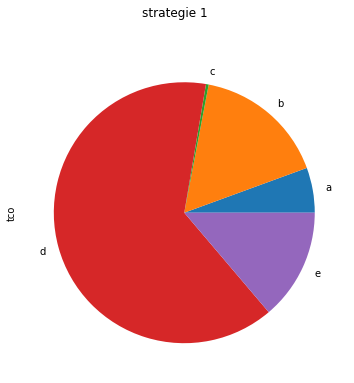

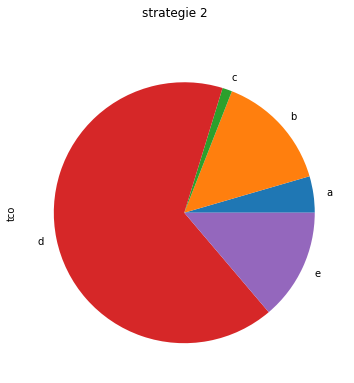

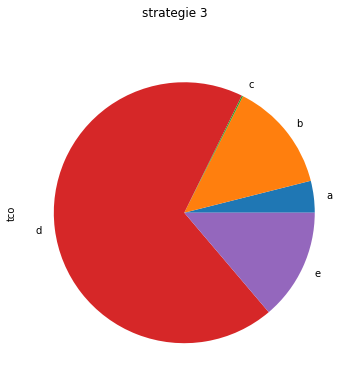

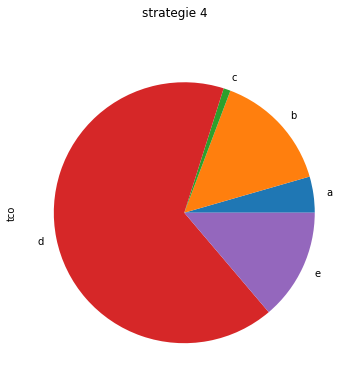

In [36]:
def make_pie_chart(result):        
    
    for i in range(nr_of_strategies):
        name = 'strategie {}'.format(i+1)
        df = result[name]
        df2 = pd.DataFrame({'tco':[avg(df['a']),avg(df['b']),avg(df['c']),avg(df['d']),avg(df['e'])]},
                       index = ['a', 'b', 'c', 'd', 'e'])
         
        # plot data frame    
        ax = df2.plot.pie(subplots=True, figsize=(11, 6),legend=False,title=name)

nr_of_strategies = 4
make_pie_chart(result)

### Calculate and plot the TCO and CO2 emissions for a fleet of vehicles

We can calculate for a company the best 'transition strategy' for each vehicle they own and what the total emissions are for their entire fleet. Moreover, loading costs might be cheaper when vehicles can share a loading pole (N.B. Voeg dit toe).

In [37]:
def read_vehicle_details(nr_of_vehicles):
    # open sheet companies
    wp = wb.sheets['wagenpark']

    # initiate vehicle
    vehicle = []

    # read vehicle details company A
    for i in range(1,nr_of_vehicles+2):
        index = 'B' + str(i) + ':' + 'J' + str(i)
        vehicle.append(wp.range(index).value)
    
    return vehicle

Insert the details for a vehicle in the sheet.

In [38]:
def write_vehicle_details(vehicle,index):
    
    # insert vehicle details in 'TCO module ondernemers' 
    ws.range('B12').value = vehicle[index][0] 
    ws.range('B13').value = vehicle[index][2]
    ws.range('B14').value = vehicle[index][3] 
    ws.range('B15').value = vehicle[index][4]
    
    # return age of vehicle
    return year[0] - vehicle[index][1]

List all vehicles of a company and put in a table.

In [39]:
# Select number of vehicles and type in fleet
nr_of_vehicles = int(input('Aantal voertuigen: '))

# read vehicle details
vehicle = read_vehicle_details(nr_of_vehicles)

# Convert the vehicle dictionary into dataframe 
df = pd.DataFrame([vehicle[1]],
                  columns= vehicle[0])       

for i in range(1,nr_of_vehicles):
    df.loc[i] = vehicle[i+1]

# display dataframe
display(HTML(df.to_html()))

Aantal voertuigen: 6


,type,jaar van aanschaf,gekoeld,Verwacht jaarkilometrage,Grijze/groene elektriciteit,max dagkilometrage,rijdt op (toekomstige) ZE zone,flexibel inzetbaar,technologische levensduur
0,Grote bakwagen (18t),2015.0,nee,35000.0,grijs,200.0,nee,nee,7.0
1,Grote bakwagen (18t),2017.0,nee,50000.0,grijs,300.0,nee,nee,7.0
2,Kleine bakwagen (12t),2016.0,nee,30000.0,groen,150.0,ja,nee,10.0
3,Trekker-oplegger,2020.0,nee,40000.0,grijs,140.0,nee,nee,7.0
4,Kleine bakwagen (12t),2019.0,nee,20000.0,grijs,600.0,nee,nee,8.0
5,Grote bakwagen (18t),2016.0,nee,45000.0,groen,300.0,ja,nee,7.0


Calculate the results.

In [40]:
# parameters
extra_years = 3
nr_of_strategies = 4

# initiate vectors
collection_of_vehicles = {}

# call different strategies for all vehicles
for i in range(nr_of_vehicles):
    age = write_vehicle_details(vehicle,i+1)
    name = 'voertuig {}'.format(i+1)
    collection_of_vehicles[name] = call_strategies(nr_of_strategies,age, extra_years)

# example
df = collection_of_vehicles['voertuig 5']['strategie 4']
display(HTML(df.to_html()))

,tco,a,b,c,d,e,co2
2021,109197.8830,4669.8770,15522.2291,0.0,73944.0,15061.7770,11.608528
2022,109197.8830,4669.8770,15522.2291,0.0,73944.0,15061.7770,11.608528
2023,109197.8830,4669.8770,15522.2291,0.0,73944.0,15061.7770,11.608528
2024,109197.8830,4669.8770,15522.2291,0.0,73944.0,15061.7770,11.608528
2025,109197.8830,4669.8770,15522.2291,0.0,73944.0,15061.7770,11.608528
2026,115263.7691,5318.6397,20102.6785,0.0,73944.0,15898.4509,11.608528
2027,114127.4508,5954.4484,18040.2850,447.0,73944.0,15741.7173,4.052855
2028,114127.4508,5954.4484,18040.2850,447.0,73944.0,15741.7173,4.052855
2029,114127.4508,5954.4484,18040.2850,447.0,73944.0,15741.7173,4.052855
2030,114127.4508,5954.4484,18040.2850,447.0,73944.0,15741.7173,4.052855


Put the yearly average tco and co2 in a data frame.

In [41]:
def get_yearly_average(result,nr_of_strategies,years = nr_of_years):
    
    # convert list to float type for plotting
    tco = []
    co2 = []
    for i in range(nr_of_strategies):
        strategie = 'strategie {}'.format(i+1)
        tco.append(avg(result[strategie]['tco'],years));
        co2.append(avg(result[strategie]['co2'],years));

    # Make data frame
    df = pd.DataFrame({'strategie':['1','2', '3', '4'],
                       'TCO kosten':[tco[0],tco[1],tco[2],tco[3]],
                       'CO2 uitstoot':[co2[0],co2[1],co2[2],co2[3]]})
    
    return df

# example
get_yearly_average(result,4)

,strategie,TCO kosten,CO2 uitstoot
0,1,115773.035247,5.060278
1,2,112125.580933,6.585120
2,3,107998.483660,8.586259
3,4,111886.208867,7.084262


Put the yearly tco and co2 for each strategy in one data frame.

In [60]:
def get_yearly_costs(result,nr_of_strategies):
    
    # convert list to float type for plotting

    # Make data frame
    df = pd.DataFrame({'TCO kosten strategie 1':result['strategie 1']['tco'],
                       'CO2 uitstoot strategie 1':result['strategie 1']['co2']},
                       index = year)    
    
    for i in range(1,nr_of_strategies):    
        strategie = 'strategie {}'.format(i+1)
        df['TCO kosten strategie {}'.format(i+1)] = result[strategie]['tco']
        df['CO2 uitstoot strategie {}'.format(i+1)] = result[strategie]['co2']
    
    return df

# example for vehicle 1
get_yearly_costs(result,4)

,TCO kosten strategie 1,CO2 uitstoot strategie 1,TCO kosten strategie 2,CO2 uitstoot strategie 2,TCO kosten strategie 3,CO2 uitstoot strategie 3,TCO kosten strategie 4,CO2 uitstoot strategie 4
2021,109197.8830,11.608528,107434.7354,11.608528,109197.8830,11.608528,109197.8830,11.608528
2022,109197.8830,11.608528,107434.7354,11.608528,109197.8830,11.608528,109197.8830,11.608528
2023,125094.1229,4.052855,108304.7354,11.608528,108434.3695,11.608528,110866.6816,11.608528
2024,125094.1229,4.052855,109609.7354,11.608528,108434.3695,11.608528,110866.6816,11.608528
2025,125094.1229,4.052855,111567.2354,11.608528,108434.3695,11.608528,110866.6816,11.608528
2026,125094.1229,4.052855,115381.6288,4.052855,108434.3695,11.608528,110866.6816,11.608528
2027,125094.1229,4.052855,115381.6288,4.052855,108434.3695,11.608528,114127.4508,4.052855
2028,125094.1229,4.052855,115381.6288,4.052855,108434.3695,11.608528,114127.4508,4.052855
2029,125094.1229,4.052855,115381.6288,4.052855,108434.3695,11.608528,114127.4508,4.052855
2030,107090.1504,4.052855,115381.6288,4.052855,107090.1504,4.052855,114127.4508,4.052855


Put the total tco costs per vehicle in table format

In [62]:
# make table of results

# Convert the dictionary into DataFrame 
data = {'strategie': ['1', '2', '3', '4']} 
  
# Convert the dictionary into DataFrame 
df = pd.DataFrame(data) 
  
# Declare a list that is to be converted into a column 
for i in range(0,nr_of_vehicles):
    tco_vehicle = get_yearly_average(collection_of_vehicles['voertuig {}'.format(i+1)],nr_of_strategies)
    # add vehicle to data frame
    df['voertuig {}'.format(i+1)] = tco_vehicle['TCO kosten'] 

display(HTML(df.to_html()))

,strategie,voertuig 1,voertuig 2,voertuig 3,voertuig 4,voertuig 5,voertuig 6
0,1,135594.803220,132102.630247,115773.035247,137351.99428,112234.796800,133710.625193
1,2,129759.602533,126735.968607,112125.580933,137351.99428,111234.154827,127663.619960
2,3,123961.839873,123266.500100,107998.483660,137351.99428,109244.607967,122882.189580
3,4,128544.909613,128715.830167,111886.208867,137351.99428,111845.588313,128373.991593


Plot the average yearly tco costs until 2035 (or a different number of years) for each strategy in a bar plot. Also show how the emissions per strategy differ for wach strategy. 

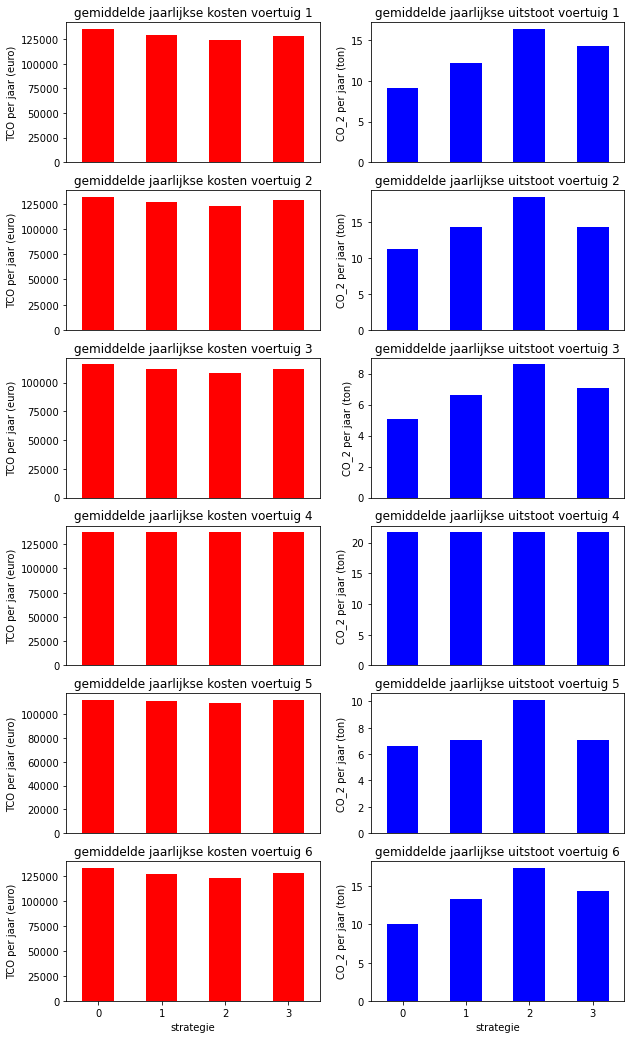

In [63]:
# initiate subplots
fig, axes = plt.subplots(figsize = (10,3*nr_of_vehicles),nrows=nr_of_vehicles, ncols=2)

# set colors
#colors = {1: 'r', 2: 'b', 3: 'g', 4:'r'}

for i in range(nr_of_vehicles):
    # plot results
    df = get_yearly_average(collection_of_vehicles['voertuig {}'.format(i+1)],nr_of_strategies)
    df['TCO kosten'].plot(ax=axes[i][0],x='strategie', y='TCO kosten',kind='bar',rot=0,color='r') #[colors[i] for i in df['strategie']]) 
    df['CO2 uitstoot'].plot(ax=axes[i][1],x='strategie', y='CO2 uitstoot',kind='bar',rot=0,color='b')
    
    axes[i][0].set_xlabel(r"strategie")
    axes[i][1].set_xlabel(r"strategie")
    axes[i][0].set_ylabel(r"TCO per jaar (euro)")
    axes[i][1].set_ylabel(r"CO_2 per jaar (ton)")
    axes[i][0].set_title(r'gemiddelde jaarlijkse kosten voertuig {}'.format(i+1))
    axes[i][1].set_title('gemiddelde jaarlijkse uitstoot voertuig {}'.format(i+1))    

# set labels between graphs non-visible
for i in range(0,nr_of_vehicles-1):
    axes[i][0].xaxis.set_visible(False)
    axes[i][1].xaxis.set_visible(False)

plt.show()  

For one vehicle compare the different strategies.

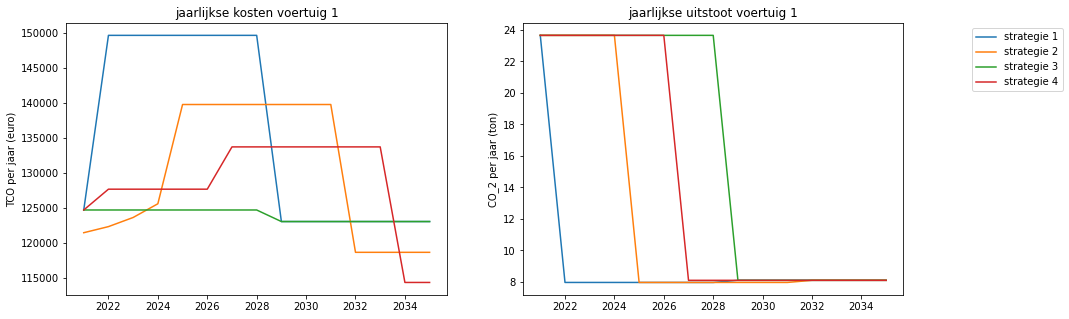

In [117]:
# initiate subplots
fig, axes = plt.subplots(figsize = (15,5),nrows=1, ncols=2)
nr_of_strategies = 4
nr_of_vehicles = 6 # N.B. haal weg

# plot tco and co2 over the years
for i in range(nr_of_strategies):
    strat = 'strategie {}'.format(i+1)
    for j in range(1):
        vt= 'voertuig {}'.format(j+1)
        df = get_yearly_costs(collection_of_vehicles[vt],4)
        df['TCO kosten ' + strat].plot(ax=axes[0],x=year, y='TCO kosten',kind='line',rot=0) 
        df['CO2 uitstoot ' + strat].plot(ax=axes[1],x=year, y='CO2 uitstoot',kind='line',rot=0,label=strat)

# set labels
axes[0].set_ylabel(r"TCO per jaar (euro)")
axes[1].set_ylabel(r"CO_2 per jaar (ton)")
axes[0].set_title(r'jaarlijkse kosten ' + vt)
axes[1].set_title('jaarlijkse uitstoot ' + vt)   

# set legend
axes[1].legend(loc='upper center', bbox_to_anchor=(1.3, 1));

plt.show() 

Put together the results for the whole fleet in one diagram.

In [64]:
# sum up the results of all vehicles
sum_of_vehicles = {}
number_of_strategies = 4 # N.B. haal weg
number_of_vehicles = 6 # N.B. haal weg

for i in range(number_of_strategies):
    # loop over strategies
    strat = 'strategie {}'.format(i+1) 
    s = 0
    for j in range(number_of_vehicles):
        # add dataframe to sum for each vehicle
        vt = 'voertuig {}'.format(j+1)
        s += collection_of_vehicles[vt][strat] 
    # add to new dictionary
    sum_of_vehicles[strat] = s

# divide by number of vehicles  
#avg_of_vehicles = {k: v / nr_of_vehicles for k, v in sum_of_vehicles.items()}

# put the results in a data frame
df1 = get_yearly_average(sum_of_vehicles,4)
df2 = get_yearly_costs(sum_of_vehicles, 4)

# display the average results for all vehicles 
display(HTML(df1.to_html())) # averaged over all years
display(HTML(df2.to_html())) # yearly change per strategy

,strategie,TCO kosten,CO2 uitstoot
0,1,766767.884987,63.680635
1,2,744870.921140,75.159067
2,3,724705.615460,92.688117
3,4,746718.522833,78.830663


,TCO kosten strategie 1,CO2 uitstoot strategie 1,TCO kosten strategie 2,CO2 uitstoot strategie 2,TCO kosten strategie 3,CO2 uitstoot strategie 3,TCO kosten strategie 4,CO2 uitstoot strategie 4
2021,731910.2568,130.178168,719751.9317,130.178168,731910.2568,130.178168,731910.2568,130.178168
2022,756838.0354,114.495654,720621.9317,130.178168,731910.2568,130.178168,734879.5499,130.178168
2023,794533.2706,91.257466,723666.9317,130.178168,729741.9480,130.178168,739619.0223,130.178168
2024,812671.1087,75.574952,729104.4317,130.178168,728945.2215,130.178168,745422.4469,130.178168
2025,812671.1087,75.574952,748492.6805,114.495654,728945.2215,130.178168,745422.4469,130.178168
2026,818854.8545,68.019279,765389.1640,91.392283,728721.4198,130.178168,751488.3330,130.178168
2027,819450.8889,44.164083,778824.9322,44.433715,729317.4542,106.322973,769383.0419,44.568532
2028,819450.8889,44.164083,778824.9322,44.433715,729317.4542,106.322973,769383.0419,44.568532
2029,792873.7786,44.298899,778824.9322,44.433715,727668.1225,90.775274,769383.0419,44.568532
2030,750086.3926,44.433715,778824.9322,44.433715,724744.2805,67.671903,769383.0419,44.568532


Plot the average over all years and vehicles (until 2035).

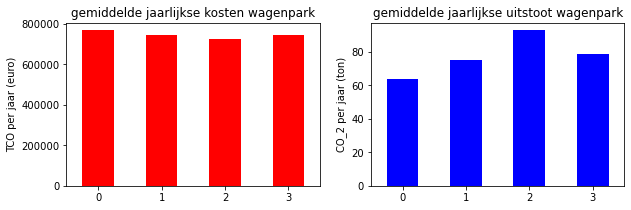

In [65]:
# initiate subplots
fig, axes = plt.subplots(figsize = (10,3),nrows=1, ncols=2)

# plot total tco and co2
df1['TCO kosten'].plot(ax=axes[0],x='strategie', y='TCO kosten',kind='bar',rot=0,legend=None,color='r') 
df1['CO2 uitstoot'].plot(ax=axes[1],x='strategie', y='CO2 uitstoot',kind='bar',rot=0,legend=None,color='b')

# set labels
axes[0].set_ylabel(r"TCO per jaar (euro)")
axes[1].set_ylabel(r"CO_2 per jaar (ton)")
axes[0].set_title(r'gemiddelde jaarlijkse kosten wagenpark')
axes[1].set_title('gemiddelde jaarlijkse uitstoot wagenpark')    

plt.show() 

Plot the average for all vehicles over the years.

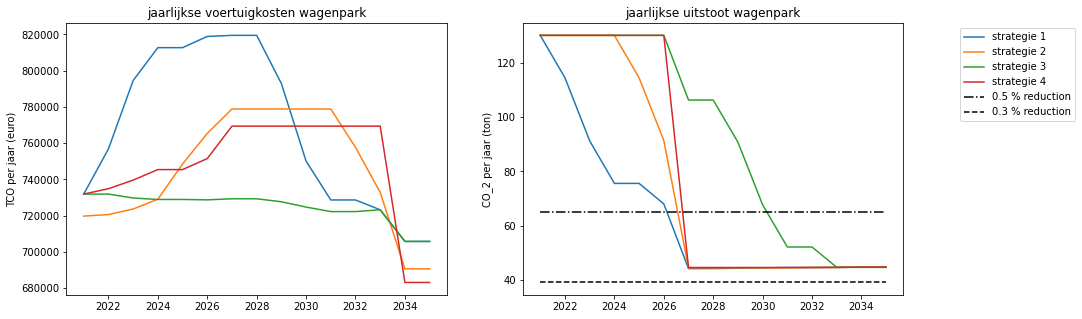

In [103]:
# initiate subplots
fig, axes = plt.subplots(figsize = (15,5),nrows=1, ncols=2)

# plot total tco and co2
for i in range(nr_of_strategies):
    strat = 'strategie {}'.format(i+1)
    df2['TCO kosten ' + strat].plot(ax=axes[0],x=year, y='TCO kosten',kind='line',rot=0) 
    df2['CO2 uitstoot ' + strat].plot(ax=axes[1],x=year, y='CO2 uitstoot',kind='line',rot=0,label=strat)

# plot line 30% emission goal in 2030
p = 0.5
q = 0.3
x = np.linspace(2021,2035,100)
y = df2['CO2 uitstoot strategie {}'.format(i+1)].loc[2021]*np.ones(100)
axes[1].plot(x,p*y,'k-.', label = '{} % reduction'.format(p));
axes[1].plot(x,q*y,'k--', label = '{} % reduction'.format(q));

# set labels
axes[0].set_ylabel(r"TCO per jaar (euro)")
axes[1].set_ylabel(r"CO_2 per jaar (ton)")
axes[0].set_title(r'jaarlijkse voertuigkosten wagenpark')
axes[1].set_title('jaarlijkse uitstoot wagenpark')   

# set legend
axes[1].legend(loc='upper center', bbox_to_anchor=(1.3, 1));

plt.show() 

### Calculate loading capacity

In [48]:
# calculate the loading capacity at 'home' and on the road for fleet of vehicles

# TO/DO

### Close Excel workbook

In [49]:
# Close Excel
wb.close()

# Sandbox

In case you want to show the output only:

In [50]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

If you want to change fonts.

HTML('''
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Courier';
font-size:.5em;
line-height:1.em;
padding-left:3em;
padding-right:3em;
}
</style>
''')